# **Libraries**

In [1]:
import wandb
import os
import pandas as pd
import requests
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
# from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:

# ✅ Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import zipfile
import os

# Provide the path to your ZIP file
zip_file_path = '/content/drive/MyDrive/archive.zip'  # Replace with your ZIP file path
extract_dir = '/content/extracted_data'  # Directory where the contents will be extracted

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to: {extract_dir}")

# Optional: Explore the directory structure
for root, dirs, files in os.walk(extract_dir):
    print(f"Directory: {root}")
    for dir_name in dirs:
        print(f"  Subdirectory: {dir_name}")
    for file_name in files:
        print(f"  File: {file_name}")


Extracted all files to: /content/extracted_data
Directory: /content/extracted_data
  Subdirectory: dataset_split
Directory: /content/extracted_data/dataset_split
  Subdirectory: train
  Subdirectory: val
  Subdirectory: test
  File: test.csv
  File: train.csv
  File: val.csv
Directory: /content/extracted_data/dataset_split/train
  Subdirectory: CN
  Subdirectory: AD
Directory: /content/extracted_data/dataset_split/train/CN
  File: ADNI_033_S_1016_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070813164707856_S33078_I67489.nii
  File: ADNI_099_S_0533_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070819141502636_S32323_I68788.nii
  File: ADNI_010_S_0067_MR_MPR____N3__Scaled_2_Br_20081001114835460_S10344_I118674.nii
  File: ADNI_009_S_0862_MR_MPR__GradWarp__N3__Scaled_Br_20070926181050051_S29424_I75401.nii
  File: ADNI_033_S_0734_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081003121738846_S16942_I119134.nii
  File: ADNI_052_S_1250_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br

# **Dataset Loading**

In [2]:
import pandas as pd
# Load the CSV data
csv_file_path='/content/drive/MyDrive/updated_train.csv'
df = pd.read_csv(csv_file_path)

In [3]:
df.shape

(951, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  951 non-null    int64 
 1   ADNI_path   951 non-null    object
 2   Group       951 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.4+ KB


In [5]:
import pandas as pd

#Shuffling the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [6]:
df.head()

,Unnamed: 0,ADNI_path,Group
0,199,/content/extracted_data/dataset_split/train/AD...,AD
1,420,/content/extracted_data/dataset_split/train/CN...,CN
2,694,/content/extracted_data/dataset_split/train/AD...,AD
3,750,/content/extracted_data/dataset_split/train/CN...,CN
4,507,/content/extracted_data/dataset_split/train/AD...,AD


In [7]:
df['Group'].unique()

array(['AD', 'CN'], dtype=object)

In [8]:
df['ADNI_path'].iloc[100]

'/content/extracted_data/dataset_split/train/CN/ADNI_002_S_1280_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20071110105845543_S38235_I81321.nii'

In [9]:
# import pandas as pd

# # Load CSV
# csv_path = "/content/extracted_data/dataset_split/val.csv"  # Update with your actual path
# df = pd.read_csv(csv_path)

# # Check column names
# print("Column names in CSV:", df.columns)

# # Find the correct column name (assuming it's 'ADNI_path')
# column_name = "ADNI_path"  # Change this if the actual name is different

# # Remove .gz extension
# df[column_name] = df[column_name].str.replace(r'\.gz$', '', regex=True)

# # Replace backslashes with forward slashes in the file paths (fixed)
# df[column_name] = df[column_name].str.replace(r'\\', '/', regex=True)

# # Update path for Google Colab
# df[column_name] = df[column_name].str.replace(r"C:/ADNI/dataset_split", "/content/extracted_data/dataset_split/val", regex=True)

# # Fix duplicate "train/train" issue
# df[column_name] = df[column_name].str.replace('/val/val/', '/val/', regex=True)

# # Save updated CSV
# updated_csv_path = "/content/drive/MyDrive/updated_val.csv"
# df.to_csv(updated_csv_path, index=False)

# print(f"CSV updated successfully! Saved at: {updated_csv_path}")


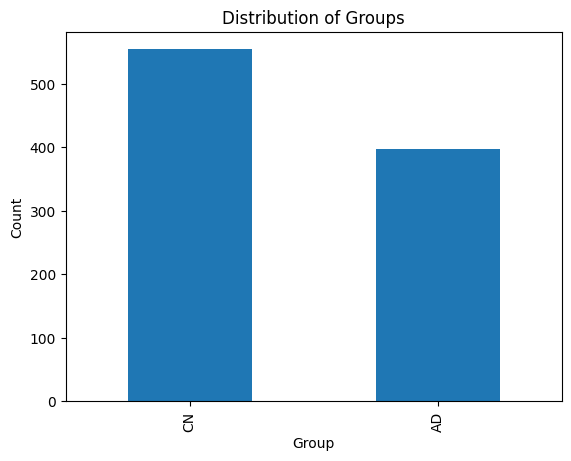

In [10]:
import matplotlib.pyplot as plt

# Example: Distribution of groups
group_counts = df['Group'].value_counts()
group_counts.plot(kind='bar')
plt.title('Distribution of Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

In [11]:
# # Define a dictionary for mapping abbreviations to full forms
# # abbreviation_mapping = {
# #     "CN": "Cognitively Normal",
# #     "MCI": "Mild Cognitive Impairment",
# #     "AD": "Alzheimer's Disease",
# #     "EMCI": "Early Mild Cognitive Impairment",
# #     "SMCP": "Subjective Memory Complaint",
# #     "LMCI": "Late Mild Cognitive Impairment",
# #     "Patient": "Patient (not classified under the above cognitive groups)"
# # }

abbreviation_mapping = {
    "CN": "Cognitively Normal",
    #"MCI": "Mild Cognitive Impairment",
    "AD": "Alzheimer's Disease",
    #"EMCI": "Early Mild Cognitive Impairment",
    #"SMCP": "Subjective Memory Complaint Patient",
    #"LMCI": "Late Mild Cognitive Impairment",
    # "Patient": "Subjective Memory Complaint Patient"
}

# Replace abbreviations in the dataset's 'Group' column with their full forms
df['Group'] = df['Group'].map(abbreviation_mapping)


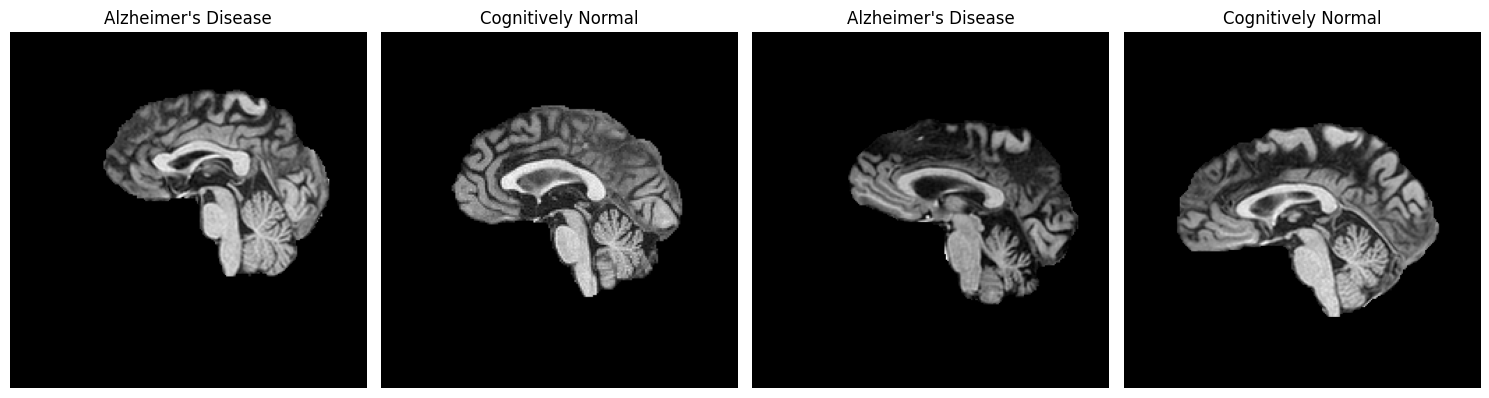

In [12]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Select 4 images to display
image_paths = df['ADNI_path'].head(4)  # Update column name if needed
labels = df['Group'].head(4)

# Create a subplot grid (1 row, 4 columns)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Loop through each image path and display it
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    try:
        # Load the NIfTI image
        img = nib.load(img_path)
        img_data = img.get_fdata()  # Convert to NumPy array

        # Select the middle slice (assuming axial view)
        middle_slice = img_data.shape[2] // 2
        slice_data = img_data[:, :, middle_slice]

        # Display the image
        axes[i].imshow(slice_data, cmap='gray')  # Show in grayscale
        axes[i].axis('off')  # Hide the axis
        axes[i].set_title(label)  # Set the title as the label (group)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        axes[i].axis('off')  # If the image can't be loaded, hide the axis

# Show the plot with the images and their labels
plt.tight_layout()
plt.show()


### **Validation Dataset**

In [13]:
val_csv_file_path='/content/drive/MyDrive/balanced_val.csv'
val_df = pd.read_csv(val_csv_file_path)

In [14]:
val_df.shape

(64, 3)

In [15]:
# # Ensure equal samples per group
# subset_val_df = val_df.groupby("Group").apply(lambda x: x.sample(n=272, random_state=42)).reset_index(drop=True)

In [16]:
# subset_val_df.shape

In [17]:
# #Shuffling the data
# subset_val_df  = subset_val_df .sample(frac=1, random_state=42).reset_index(drop=True)

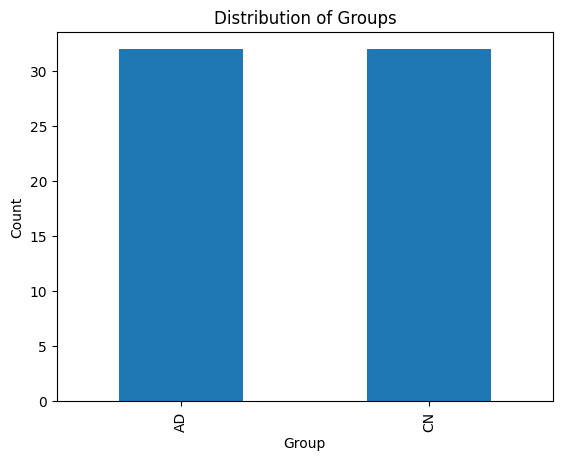

In [18]:
import matplotlib.pyplot as plt

# Example: Distribution of groups
group_counts = val_df['Group'].value_counts()
group_counts.plot(kind='bar')
plt.title('Distribution of Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

In [19]:
val_df.head()

,Unnamed: 0,ADNI_path,Group
0,90,/content/extracted_data/dataset_split/val/AD/A...,AD
1,101,/content/extracted_data/dataset_split/val/AD/A...,AD
2,49,/content/extracted_data/dataset_split/val/CN/A...,CN
3,34,/content/extracted_data/dataset_split/val/AD/A...,AD
4,106,/content/extracted_data/dataset_split/val/CN/A...,CN


In [19]:
import pandas as pd

# Load validation dataset
val_df = pd.read_csv("/content/drive/MyDrive/updated_val.csv")

# Separate CN and AD classes
cn_df = val_df[val_df["Group"] == "CN"]
ad_df = val_df[val_df["Group"] == "AD"]

# Randomly sample 40 CN examples
cn_df_sampled = cn_df.sample(n=len(ad_df), random_state=42)

# Concatenate to create a balanced dataset
balanced_val_df = pd.concat([cn_df_sampled, ad_df])

# Shuffle the dataset
balanced_val_df = balanced_val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check distribution
print(balanced_val_df["Group"].value_counts())

# Save balanced dataset
balanced_val_df.to_csv("/content/drive/MyDrive/balanced_val.csv", index=False)


Group
AD    32
CN    32
Name: count, dtype: int64


Column names in Validation CSV: Index(['Unnamed: 0', 'ADNI_path', 'Group'], dtype='object')


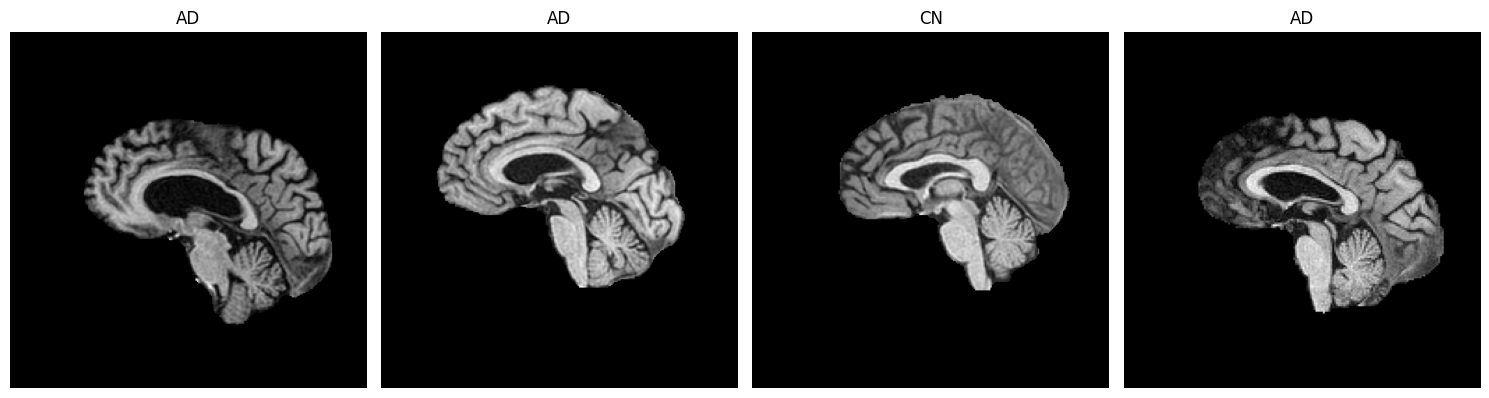

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Load validation CSV
val_csv_path = "/content/drive/MyDrive/balanced_val.csv"  # Update the path if needed
df_val = pd.read_csv(val_csv_path)

# Check column names
print("Column names in Validation CSV:", df_val.columns)

# Select 4 images from validation data
image_paths = df_val['ADNI_path'].head(4)  # Ensure column name is correct
labels = df_val['Group'].head(4)  # Adjust based on actual column name

# Create a subplot grid (1 row, 4 columns)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Loop through each image path and display it
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    try:
        # Load the NIfTI image
        img = nib.load(img_path)
        img_data = img.get_fdata()  # Convert to NumPy array

        # Select the middle slice (assuming axial view)
        middle_slice = img_data.shape[2] // 2
        slice_data = img_data[:, :, middle_slice]

        # Display the image
        axes[i].imshow(slice_data, cmap='gray')  # Show in grayscale
        axes[i].axis('off')  # Hide the axis
        axes[i].set_title(label)  # Set the title as the label (group)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        axes[i].axis('off')  # If the image can't be loaded, hide the axis

# Show the plot with the images and their labels
plt.tight_layout()
plt.show()


#3d training overfitting

In [21]:
pip install monai


In [22]:
!pip install torchmetrics


In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, Resize, ScaleIntensity
from tqdm import tqdm  # ✅ Progress bar

# ✅ Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Dictionary for replacing abbreviations
abbreviation_mapping = {
    "CN": "Cognitively Normal",
    "AD": "Alzheimer's Disease"
}

# ✅ Label encoding
label_mapping = {
    "Alzheimer's Disease": 0,
    "Cognitively Normal": 1
}

# ✅ Load data
train_df = pd.read_csv("/content/drive/MyDrive/updated_train.csv")[["ADNI_path", "Group"]]
val_df = pd.read_csv("/content/drive/MyDrive/balanced_val.csv")[["ADNI_path", "Group"]]

# ✅ Replace abbreviations & drop NaNs
train_df["Group"] = train_df["Group"].map(abbreviation_mapping)
val_df["Group"] = val_df["Group"].map(abbreviation_mapping)
train_df.dropna(subset=["Group"], inplace=True)
val_df.dropna(subset=["Group"], inplace=True)

# ✅ Function to load 3D NIfTI images
def load_3d_image(file_path):
    img = nib.load(file_path).get_fdata()
    img = np.expand_dims(img, axis=0)  # ✅ Add channel dimension (1, D, H, W)
    return torch.tensor(img, dtype=torch.float32)

# ✅ Define Dataset Class
class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["ADNI_path"]
        label = self.data.iloc[idx]["Group"]

        # ✅ Convert label to integer
        label = label_mapping[label]
        label = torch.tensor(label, dtype=torch.long)

        # ✅ Load and transform the image
        image = load_3d_image(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label

# ✅ Define Transformations
transform = Compose([
    ScaleIntensity(),  # Normalize intensity values
    Resize((64, 64, 64))  # Resize to 64x64x64
])

# ✅ Create datasets and dataloaders
train_dataset = MRIDataset(train_df, transform=transform)
val_dataset = MRIDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# ✅ Initialize DenseNet3D Model
model = DenseNet121(
    spatial_dims=3,  # ✅ 3D Model
    in_channels=1,  # ✅ Single-channel MRI images
    out_channels=2  # ✅ Binary classification (Alzheimer's vs Normal)
).to(device)

# ✅ Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)

# ✅ Mixed Precision Training
scaler = torch.amp.GradScaler()

# ✅ Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5)

# ✅ Training function with gradient accumulation
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, accumulation_step=2):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        optimizer.zero_grad()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for step, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            # ✅ Mixed precision training
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_step  # Normalize loss

            # ✅ Scale loss and backprop
            scaler.scale(loss).backward()

            if (step + 1) % accumulation_step == 0:  # ✅ Update weights after accumulation step
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_step
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(Loss=loss.item() * accumulation_step, Accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # ✅ Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model Saved!")

        if early_stopper.should_stop(val_loss):
            print("⏹️ Early stopping triggered!")
            break

# ✅ Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    # ✅ Print sample predictions
    print("\nSample Predictions:")
    for i in range(min(5, len(predictions))):
        pred_label = list(label_mapping.keys())[list(label_mapping.values()).index(predictions[i])]
        true_label = list(label_mapping.keys())[list(label_mapping.values()).index(true_labels[i])]
        print(f"  Predicted: {pred_label}, True: {true_label}")

    return val_loss, val_acc

# ✅ Start Training
torch.cuda.empty_cache()
train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, accumulation_step=2)


Using device: cuda


Epoch 1/10: 100%|██████████| 238/238 [06:45<00:00,  1.70s/it, Accuracy=62.1, Loss=0.667]



Sample Predictions:
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 1 - Train Loss: 0.6563, Train Acc: 62.15% | Val Loss: 0.7655, Val Acc: 62.50%
✅ Model Saved!


Epoch 2/10: 100%|██████████| 238/238 [06:12<00:00,  1.56s/it, Accuracy=70.2, Loss=0.567]



Sample Predictions:
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 2 - Train Loss: 0.5711, Train Acc: 70.24% | Val Loss: 0.7636, Val Acc: 64.06%
✅ Model Saved!


Epoch 3/10: 100%|██████████| 238/238 [06:20<00:00,  1.60s/it, Accuracy=77.2, Loss=1.24]



Sample Predictions:
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 3 - Train Loss: 0.4943, Train Acc: 77.18% | Val Loss: 0.6361, Val Acc: 73.44%
✅ Model Saved!


Epoch 4/10: 100%|██████████| 238/238 [06:13<00:00,  1.57s/it, Accuracy=82, Loss=0.137]



Sample Predictions:
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 4 - Train Loss: 0.4112, Train Acc: 82.02% | Val Loss: 1.2275, Val Acc: 59.38%


Epoch 5/10: 100%|██████████| 238/238 [06:17<00:00,  1.59s/it, Accuracy=82, Loss=0.0757]



Sample Predictions:
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 5 - Train Loss: 0.3910, Train Acc: 82.02% | Val Loss: 1.3445, Val Acc: 64.06%


Epoch 6/10: 100%|██████████| 238/238 [06:05<00:00,  1.54s/it, Accuracy=86.2, Loss=0.444]



Sample Predictions:
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 6 - Train Loss: 0.3276, Train Acc: 86.23% | Val Loss: 0.9580, Val Acc: 65.62%


Epoch 7/10: 100%|██████████| 238/238 [06:08<00:00,  1.55s/it, Accuracy=87.4, Loss=0.506]



Sample Predictions:
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 7 - Train Loss: 0.2952, Train Acc: 87.38% | Val Loss: 1.7818, Val Acc: 62.50%


Epoch 8/10: 100%|██████████| 238/238 [06:13<00:00,  1.57s/it, Accuracy=91.3, Loss=0.0505]



Sample Predictions:
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Epoch 8 - Train Loss: 0.2286, Train Acc: 91.27% | Val Loss: 0.7824, Val Acc: 75.00%
⏹️ Early stopping triggered!


In [27]:

val_df = pd.read_csv("/content/drive/MyDrive/balanced_val.csv")[["ADNI_path", "Group"]]

val_df["Group"] = val_df["Group"].map(abbreviation_mapping)
val_df.dropna(subset=["Group"], inplace=True)

val_dataset = MRIDataset(val_df, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")



Sample Predictions:
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Val Loss: 0.7824, Val Acc: 75.00%


In [29]:
import pandas as pd

# Load validation dataset
val_df = pd.read_csv("/content/drive/MyDrive/updated_test.csv")

# Separate CN and AD classes
cn_df = val_df[val_df["Group"] == "CN"]
ad_df = val_df[val_df["Group"] == "AD"]

# Randomly sample 40 CN examples
cn_df_sampled = cn_df.sample(n=len(ad_df), random_state=42)

# Concatenate to create a balanced dataset
balanced_val_df = pd.concat([cn_df_sampled, ad_df])

# Shuffle the dataset
balanced_val_df = balanced_val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check distribution
print(balanced_val_df["Group"].value_counts())

# Save balanced dataset
balanced_val_df.to_csv("/content/drive/MyDrive/balanced_test.csv", index=False)


Group
CN    47
AD    47
Name: count, dtype: int64


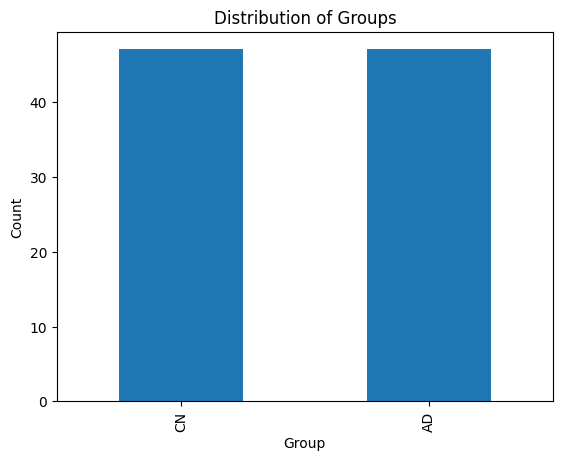

In [30]:
updated_test_path='/content/drive/MyDrive/balanced_test.csv'
test_df = pd.read_csv(updated_test_path)

import matplotlib.pyplot as plt

# Example: Distribution of groups
group_counts = test_df['Group'].value_counts()
group_counts.plot(kind='bar')
plt.title('Distribution of Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

In [32]:
test_df = pd.read_csv("/content/drive/MyDrive/balanced_test.csv")[["ADNI_path", "Group"]]

test_df["Group"] = test_df["Group"].map(abbreviation_mapping)
test_df.dropna(subset=["Group"], inplace=True)

test_dataset = MRIDataset(test_df, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")



Sample Predictions:
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Cognitively Normal
  Predicted: Cognitively Normal, True: Alzheimer's Disease
  Predicted: Alzheimer's Disease, True: Alzheimer's Disease
  Predicted: Cognitively Normal, True: Cognitively Normal
Test Loss: 1.0508, Test Acc: 63.83%


# **Dataset Class**

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class AlzheimerImageDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, image_size):
        """
        Initialize the AlzheimerImageDataset.

        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels.
            tokenizer: Tokenizer for processing text labels.
            max_length (int): Maximum length for tokenized labels.
            image_size (int or tuple): Size to which images should be resized (square dimensions).
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Ensure image_size is a tuple of integers (width, height)
        self.image_size = (image_size, image_size) if isinstance(image_size, int) else image_size

    def __len__(self):
        """
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Fetch a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: Dictionary containing image tensor ('pixel_values') and label tensor ('labels').
        """
        if idx >= len(self.dataframe):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.dataframe)}.")

        # Retrieve the row corresponding to the given index
        row = self.dataframe.iloc[idx]
        text = row['Group']  # Alzheimer's disease stage (label)
        image_path = row['Image_Path']

        # Load and transform the image
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.image_transform_function(image)
        except (FileNotFoundError, IOError):
            raise ValueError(f"Invalid image file at index {idx}: {image_path}")
            return None

        # Tokenize the label text
        encodings = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )

        # Return image tensor and tokenized labels
        return {
            'pixel_values': image,  # Image tensor
            'labels': encodings['input_ids'].squeeze(0),  # Flatten tensor for model input
            'attention_mask': encodings['attention_mask'].squeeze(0)  # Ensure attention mask is included
        }

    def image_transform_function(self, image):
        """
        Apply transformations to the input image.

        Args:
            image (PIL.Image): Input image to be transformed.

        Returns:
            torch.Tensor: Transformed image tensor.
        """
        transform = transforms.Compose([
            transforms.Resize(self.image_size),  # Resize to specified dimensions
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image
        ])
        return transform(image)


In [ ]:
# Create dataset and dataloaders
from sklearn.model_selection import train_test_split

max_length = 128  # max length for tokenization
image_size = (128, 128)

train_dataset = AlzheimerImageDataset(df, tokenizer, max_length, image_size)
val_dataset = AlzheimerImageDataset(val_df, tokenizer, max_length, image_size)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Split the dataset into training and validation datasets
# train_dataframe, val_dataframe = train_test_split(df, test_size=0.05, random_state=42)
# val_dataframe, test_dataframe = train_test_split(val_dataframe, test_size=0.026 , random_state=42)
# test_dataset = AlzheimerImageDataset(test_dataframe, tokenizer, max_length, image_size)
# test_loader = DataLoader(test_dataset, batch_size=14)

NameError: name 'AlzheimerImageDataset' is not defined

In [ ]:


print(df.shape)
print(val_df.shape)
#print(train_dataframe.shape)
#print(val_dataframe.shape)
# print(test_dataframe.shape)

(951, 3)
(110, 3)


# **Training**

In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id,reduction='none')

In [ ]:
def evaluate(model, val_loader, tokenizer, device, criterion, log_every=50, verbose=False):
    """
    Evaluate the model on a validation dataset and calculate accuracy.

    Args:
        model: The trained model.
        val_loader: DataLoader for the validation dataset.
        tokenizer: Tokenizer for decoding model outputs and labels.
        device: The device ('cuda' or 'cpu') to run evaluation.
        criterion: Loss function for evaluation.
        log_every: Frequency of verbose logging (batches).
        verbose: Whether to log predictions and labels during evaluation.

    Returns:
        avg_loss: Average validation loss over the dataset.
        accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Track cumulative loss
    total_correct = 0  # Track correct predictions
    total_samples = 0  # Track the number of samples processed

    with torch.no_grad():  # Disable gradient computation
        for batch_counter, batch in enumerate(val_loader):
            # Move data to the device
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)  # Tokenized text labels
            attention_mask = (labels != tokenizer.pad_token_id).long()

            # Forward pass
            outputs = model(
                pixel_values=images,
                input_ids=labels[:, :-1],  # Use teacher forcing (excluding last token)
                labels=labels[:, 1:],  # Shift labels for loss calculation
                attention_mask=attention_mask[:, :-1]
            )
            loss = outputs.loss
            total_loss += loss.item()
            total_samples += labels.size(0)

            # Generate predictions
            generated_tokens = model.generate(
                pixel_values=images,
                max_length=labels.size(1),
                num_beams=4,
                no_repeat_ngram_size=3
            )
            # Decode predictions and ground truth labels
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Calculate batch accuracy
            correct = sum([1 for pred, true in zip(decoded_preds, decoded_labels) if pred == true])
            total_correct += correct

            # Optional verbose logging
            if verbose and (batch_counter + 1) % log_every == 0:
                print(f"\nBatch {batch_counter + 1}: Validation Loss: {loss.item():.4f}")
                for i, (pred, true_label) in enumerate(zip(decoded_preds, decoded_labels)):
                    print(f"Sample {i + 1}:\n  Predicted: {pred}\n  True: {true_label}")

    # Calculate average loss over all samples
    avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else float('nan')

    # Calculate overall accuracy
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    print(f"\nValidation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import os

# Define base save path with flexibility
# base_save_path = os.getenv("MODEL_SAVE_PATH", "/content/drive/MyDrive/Alzheimer_Disease_Dataset/")

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, tokenizer, device, num_epochs, start_epoch=0, start_step=0, best_val_loss=float('inf'), train_metrics=None, val_metrics=None, save_path=None,accumulation_step=2):
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    # Initialize metrics if not provided
    if train_metrics is None:
        train_metrics = []
    if val_metrics is None:
        val_metrics = []

    optimizer.zero_grad()

    try:
        for epoch in range(start_epoch, num_epochs):
            total_train_loss = 0
            total_correct = 0
            total_samples = 0
            batch_count = 0

            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}")

            for step, batch in enumerate(train_loader_tqdm):
                if step < start_step:
                    continue
                if batch is None or any(v is None for v in batch.values()):
                    train_loader_tqdm.set_postfix({"Status": "Skipping None batch"})
                    continue

                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                attention_mask = (labels != tokenizer.pad_token_id).long()

                with torch.cuda.amp.autocast():
                    outputs = model(
                        input_ids=labels,
                        pixel_values=pixel_values,
                        labels=labels,
                        attention_mask=attention_mask
                    )
                    loss = outputs.loss / accumulation_step  # Gradient accumulation steps fixed at 2

                scaler.scale(loss).backward()

                if (step + 1) % accumulation_step == 0 or step == len(train_loader) - 1:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                total_train_loss += loss.item()
                batch_count += 1

                num_ngrams = max(1, min(3, labels.size(1) // 2))
                generated_tokens = model.generate(
                    pixel_values=pixel_values,
                    max_length=labels.size(1),
                    num_beams=4,
                    no_repeat_ngram_size=num_ngrams
                )
                decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
                decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
                correct = sum([1 for pred, true in zip(decoded_preds, decoded_labels) if pred == true])
                total_correct += correct
                total_samples += labels.size(0)

                train_accuracy = total_correct / total_samples if total_samples > 0 else 0
                train_loader_tqdm.set_postfix({"Loss": loss.item() * accumulation_step, "Accuracy": f"{train_accuracy:.4f}"})

                validation_interval = max(10, len(train_loader) // 5) # after 132
                if (step + 1) % validation_interval == 0:
                    avg_step_loss = total_train_loss / batch_count if batch_count > 0 else float('inf')
                    train_metrics.append({"Chunk 2, epoch": epoch, "step": step, "loss": avg_step_loss, "accuracy": train_accuracy})
                    print(f"\nStep: {step + 1}, Average Training Loss: {avg_step_loss}, Training Accuracy: {train_accuracy:.4f}")

                    val_loss, val_accuracy = evaluate(model, val_loader, tokenizer, device, criterion, log_every=100, verbose=True)
                    val_metrics.append({"Chunk 2, epoch": epoch, "step": step, "loss": val_loss, "accuracy": val_accuracy})

                    scheduler.step(val_loss)

                    print(f"Current LR: {optimizer.param_groups[0]['lr']}, Patience Counter: {scheduler.num_bad_epochs}")


                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        torch.save(model.state_dict(), 'best_model.pth')
                        train_loader_tqdm.set_postfix({"Validation Loss": val_loss, "Validation Accuracy": f"{val_accuracy:.4f}", "Model Saved": True})

                if (step + 1) % 560 == 0 and save_path:
                    checkpoint_path = os.path.join(save_path, f"intermediate_model_chunk_2_epoch_{epoch}_step_{step}.pth")
                    torch.save({
                        "epoch": epoch,
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "train_metrics": train_metrics,
                        "val_metrics": val_metrics,
                        "loss": loss.item()
                    }, checkpoint_path)
                    print(f"Intermediate model saved at {checkpoint_path}")

            avg_train_loss = total_train_loss / batch_count if batch_count > 0 else float('inf')
            train_accuracy = total_correct / total_samples if total_samples > 0 else 0
            train_metrics.append({"Chunk 2, epoch": epoch, "loss": avg_train_loss, "accuracy": train_accuracy})
            print(f"Epoch: {epoch}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy:.4f}")

    except RuntimeError as e:
      if "CUDA out of memory" in str(e):
        print("CUDA OOM Error. Saving checkpoint...")
        torch.save(model.state_dict(), "oom_checkpoint.pth")
      raise e

    return train_metrics, val_metrics, best_val_loss


# **Loading PreTrained Model**

In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/Alzheimer_Disease_Dataset/intermediate_model_chunk_2_epoch_0_step_263.pth'
save_path = '/content/drive/MyDrive/Alzheimer_Disease_Dataset'

accumulation_step=2

# Load the checkpoint if exists
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    print(f"Checkpoint loaded from: {model_path}")

    # Load model state
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model state loaded successfully.")
    else:
        print("Warning: No model state found in the checkpoint.")

    # Load optimizer and scheduler state
    if 'optimizer_state_dict' in checkpoint and 'scheduler_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Optimizer and scheduler state loaded.")
    else:
        print("Warning: Optimizer or scheduler state not found in the checkpoint.")

    # Restore training parameters
    start_epoch = checkpoint.get("epoch", 0)
    start_step = checkpoint.get("step", 0)
    best_val_loss = checkpoint.get("best_val_loss", float('inf'))
    train_metrics = checkpoint.get("train_metrics", [])
    val_metrics = checkpoint.get("val_metrics", [])
    print(f"Resuming training from epoch {start_epoch}, step {start_step}.")
else:
    start_epoch = 0
    start_step = 0
    best_val_loss = float('inf')
    train_metrics = []
    val_metrics = []
    print("No checkpoint found. Starting training from scratch.")

# Define number of epochs
num_epochs = 1  # Adjust as needed




<ipython-input-32-66cea54e41b3>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Checkpoint loaded from: /content/drive/MyDrive/Alzheimer_Disease_Dataset/intermediate_model_chunk_2_epoch_0_step_263.pth
Model state loaded successfully.
Optimizer and scheduler state loaded.
Resuming training from epoch 0, step 263.


In [ ]:
# Call the training function
train_metrics, val_metrics, best_val_loss = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, tokenizer,
    device, num_epochs, start_epoch, start_step, best_val_loss, train_metrics, val_metrics, save_path,accumulation_step
)

<ipython-input-31-a347b3b69fd3>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 0:  40%|███▉      | 263/660 [42:59<1:05:12,  9.86s/it]<ipython-input-31-a347b3b69fd3>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 0:  40%|███▉      | 263/660 [43:12<1:05:12,  9.86s/it, Loss=1.37, Accuracy=0.6875]


Step: 264, Average Training Loss: 0.6835461258888245, Training Accuracy: 0.6875

Batch 100: Validation Loss: 1.6764
Sample 1:
  Predicted: late mild cognitive impairment
  True: late mild cognitive impairment
Sample 2:
  Predicted: alzheimer ' s disease
  True: mild cognitive impairment
Sample 3:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 4:
  Predicted: early mild cognitive impairment
  True: subjective memory complaint patient
Sample 5:
  Predicted: cognitively normal
  True: early mild cognitive impairment
Sample 6:
  Predicted: cognitively normal
  True: late mild cognitive impairment
Sample 7:
  Predicted: late mild cognitive impairment
  True: alzheimer ' s disease
Sample 8:
  Predicted: cognitively normal
  True: late mild cognitive impairment
Sample 9:
  Predicted: late mild cognitive impairment
  True: early mild cognitive impairment
Sample 10:
  Predicted: alzheimer ' s disease
  True: subjective memory complaint patient
S

Epoch 0:  60%|█████▉    | 395/660 [1:26:45<48:29, 10.98s/it, Loss=0.549, Accuracy=0.6978]


Step: 396, Average Training Loss: 0.4483281438960169, Training Accuracy: 0.6978

Batch 100: Validation Loss: 0.8631
Sample 1:
  Predicted: early mild cognitive impairment
  True: late mild cognitive impairment
Sample 2:
  Predicted: alzheimer ' s disease
  True: mild cognitive impairment
Sample 3:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 4:
  Predicted: early mild cognitive impairment
  True: subjective memory complaint patient
Sample 5:
  Predicted: cognitively normal
  True: early mild cognitive impairment
Sample 6:
  Predicted: cognitively normal
  True: late mild cognitive impairment
Sample 7:
  Predicted: early mild cognitive impairment
  True: alzheimer ' s disease
Sample 8:
  Predicted: cognitively normal
  True: late mild cognitive impairment
Sample 9:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 10:
  Predicted: subjective memory complaint patient
  True: subjective memor

Epoch 0:  80%|███████▉  | 527/660 [1:53:49<24:42, 11.15s/it, Loss=0.266, Accuracy=0.7488]


Step: 528, Average Training Loss: 0.31993127442755787, Training Accuracy: 0.7488

Batch 100: Validation Loss: 0.5958
Sample 1:
  Predicted: early mild cognitive impairment
  True: late mild cognitive impairment
Sample 2:
  Predicted: early mild cognitive impairment
  True: mild cognitive impairment
Sample 3:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 4:
  Predicted: early mild cognitive impairment
  True: subjective memory complaint patient
Sample 5:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 6:
  Predicted: cognitively normal
  True: late mild cognitive impairment
Sample 7:
  Predicted: alzheimer ' s disease
  True: alzheimer ' s disease
Sample 8:
  Predicted: late mild cognitive impairment
  True: late mild cognitive impairment
Sample 9:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 10:
  Predicted: alzheimer ' s disease
  True: 

Epoch 0:  85%|████████▍ | 560/660 [2:03:16<45:48, 27.49s/it, Loss=0.231, Accuracy=0.7618]

Intermediate model saved at /content/drive/MyDrive/Alzheimer_Disease_Dataset/intermediate_model_chunk_2_epoch_0_step_559.pth


Epoch 0: 100%|█████████▉| 659/660 [2:21:51<00:10, 10.79s/it, Loss=0.159, Accuracy=0.7886]


Step: 660, Average Training Loss: 0.24787589519165024, Training Accuracy: 0.7886

Batch 100: Validation Loss: 0.4900
Sample 1:
  Predicted: late mild cognitive impairment
  True: late mild cognitive impairment
Sample 2:
  Predicted: early mild cognitive impairment
  True: mild cognitive impairment
Sample 3:
  Predicted: late mild cognitive impairment
  True: early mild cognitive impairment
Sample 4:
  Predicted: early mild cognitive impairment
  True: subjective memory complaint patient
Sample 5:
  Predicted: cognitively normal
  True: early mild cognitive impairment
Sample 6:
  Predicted: mild cognitive impairment
  True: late mild cognitive impairment
Sample 7:
  Predicted: late mild cognitive impairment
  True: alzheimer ' s disease
Sample 8:
  Predicted: late mild cognitive impairment
  True: late mild cognitive impairment
Sample 9:
  Predicted: subjective memory complaint patient
  True: early mild cognitive impairment
Sample 10:
  Predicted: late mild cognitive impairment
  True

Epoch 0: 100%|██████████| 660/660 [2:24:23<00:00, 13.13s/it, Validation Loss=0.5, Validation Accuracy=0.1985, Model Saved=1]

Epoch: 0, Average Training Loss: 0.24787589519165024, Training Accuracy: 0.7886


### **Saving Model For Training**

In [ ]:
# Define the path where you want to save the model
save_path = "/content/drive/MyDrive/Alzheimer_Disease_Dataset/final_model_chunk_2_epoch_0.pth"

# Save the model along with training and validation metrics
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_metrics': train_metrics,  # Using train_metrics instead of train_losses
    'val_metrics': val_metrics,      # Using val_metrics instead of val_losses
    'best_val_loss': best_val_loss
}, save_path)

print(f"Final Model saved successfully at {save_path}. You can resume training from this checkpoint.")


Final Model saved successfully at /content/drive/MyDrive/Alzheimer_Disease_Dataset/final_model_chunk_2_epoch_0.pth. You can resume training from this checkpoint.


### **Saving Model For Testing**

In [ ]:
# Define the path where you want to save the model for testing
test_model_path = "/content/drive/MyDrive/Alzheimer_Disease_Dataset/final_model_for_testing.pth"

# Save only the model's state_dict
torch.save({
    "model_state_dict": model.state_dict()
}, test_model_path)

print(f"Model saved successfully for testing at {test_model_path}")


Model saved successfully for testing at /content/drive/MyDrive/Alzheimer_Disease_Dataset/final_model_for_testing.pth


# **Testing**

In [ ]:
test_model_path = "/content/best_model.pth"
# Load model for testing
checkpoint = torch.load(test_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()  # Set to evaluation mode
print("Model loaded successfully for testing.")


<ipython-input-28-47a2984c3381>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(test_model_path, map_location=device)


KeyError: 'model_state_dict'

In [ ]:
# Fetch a single batch from the validation loader
batch = next(iter(test_loader))
images = batch['pixel_values'].to(device)
true_labels = batch['labels'].to(device)

# Generate predictions using the model
generated_tokens = model.generate(
    pixel_values=images,
    max_length=true_labels.size(1),
    num_beams=4,
    no_repeat_ngram_size=3
)

# Decode predictions and true labels
predicted_sentences = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
true_sentences = tokenizer.batch_decode(true_labels, skip_special_tokens=True)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_batch_metrics(predicted_sentences, true_sentences):
    """
    Calculate F1-score, Precision, and Recall for a single batch.
    """
    y_true = [1 if pred == true else 0 for pred, true in zip(predicted_sentences, true_sentences)]
    y_pred = [1] * len(true_sentences)  # All ground truths are correct

    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    return precision, recall, f1

# Calculate metrics
precision, recall, f1 = calculate_batch_metrics(predicted_sentences, true_sentences)

print("\nMetrics for Single Batch:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:

# Calculate metrics for the batch
precision, recall, f1 = calculate_batch_metrics(predicted_sentences, true_sentences)

# Print F1-score and detailed predictions
print("\nMetrics for Single Batch:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print detailed predictions and true labels
for i, (pred, true) in enumerate(zip(predicted_sentences, true_sentences)):
    print(f"Sample {i + 1}:")
    print(f"  Predicted: {pred}")
    print(f"  True: {true}")
    print("-" * 40)


# **Graphs**

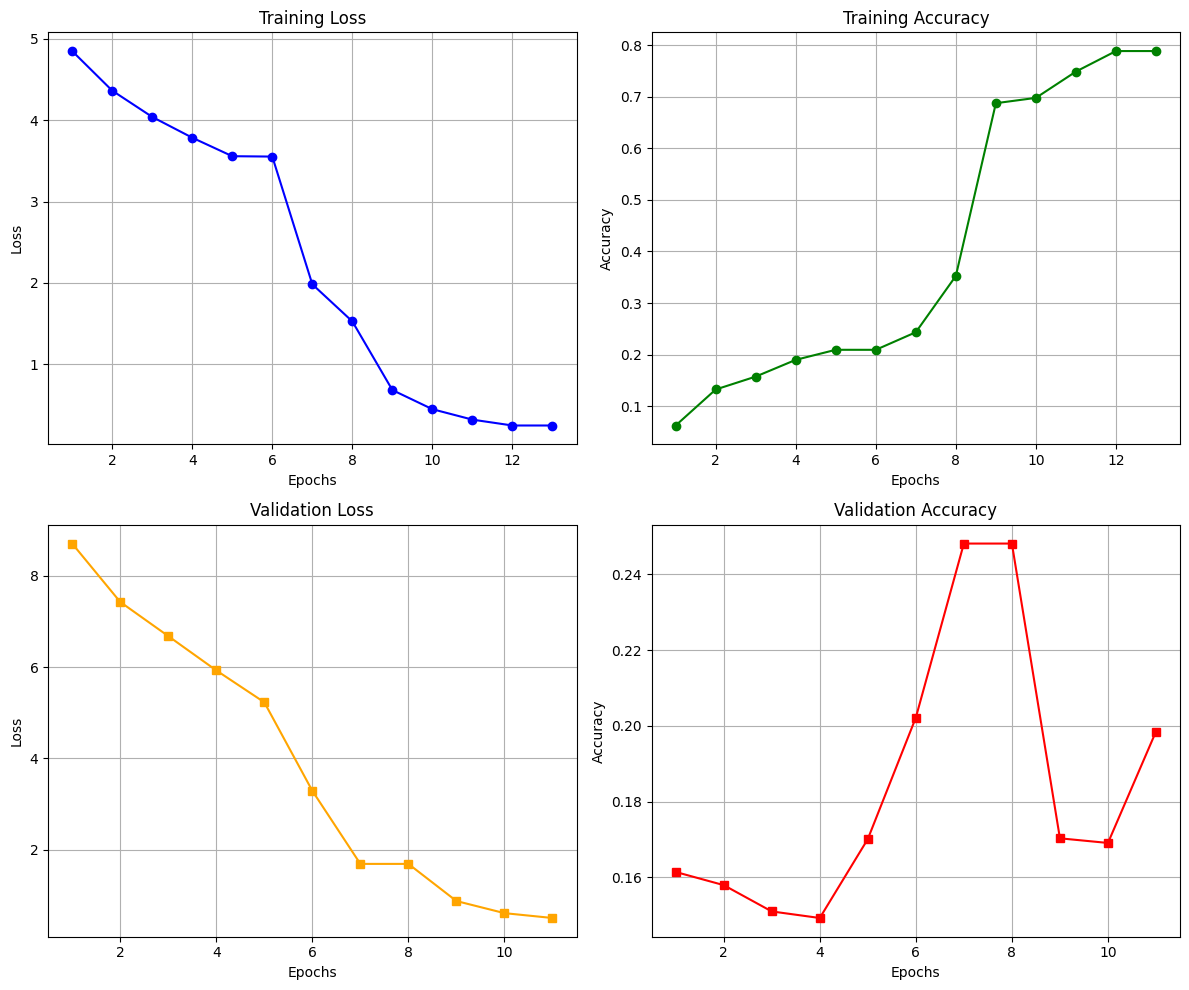

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values for training and validation
train_loss_values = [d['loss'] for d in train_metrics]
train_accuracy_values = [d['accuracy'] for d in train_metrics]
val_loss_values = [d['loss'] for d in val_metrics]
val_accuracy_values = [d['accuracy'] for d in val_metrics]

# Create a figure for all plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Plot Training Loss
axes[0, 0].plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Training Loss", marker='o', color='blue')
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].grid(True)

# Plot Training Accuracy
axes[0, 1].plot(range(1, len(train_accuracy_values) + 1), train_accuracy_values, label="Training Accuracy", marker='o', color='green')
axes[0, 1].set_title("Training Accuracy")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].grid(True)

# Plot Validation Loss
axes[1, 0].plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss", marker='s', color='orange')
axes[1, 0].set_title("Validation Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].grid(True)

# Plot Validation Accuracy
axes[1, 1].plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label="Validation Accuracy", marker='s', color='red')
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
print("Training Losses:")
for loss in train_metrics:
    print(loss)

# Printing validation losses
print("\nValidation Losses:")
for loss in val_metrics:
    print(loss)

Training Losses:
{'Chunk 1, epoch': 0, 'step': 46, 'loss': 4.850571794712797, 'accuracy': 0.0625}
{'Chunk 1, epoch': 0, 'step': 93, 'loss': 4.3642393198419125, 'accuracy': 0.13231382978723405}
{'Chunk 1, epoch': 0, 'step': 140, 'loss': 4.040858488556341, 'accuracy': 0.1573581560283688}
{'Chunk 1, epoch': 0, 'step': 187, 'loss': 3.785570135776033, 'accuracy': 0.18982712765957446}
{'Chunk 1, epoch': 0, 'step': 234, 'loss': 3.5581352061413702, 'accuracy': 0.20930851063829786}
{'Chunk 1, epoch': 0, 'loss': 3.5534956010721497, 'accuracy': 0.20925285828237172}
{'Chunk 2, epoch': 0, 'step': 131, 'loss': 1.9834084203748992, 'accuracy': 0.24337121212121213}
{'Chunk 2, epoch': 0, 'step': 263, 'loss': 1.527213914827867, 'accuracy': 0.3525094696969697}
{'Chunk 2, epoch': 0, 'step': 263, 'loss': 0.6835461258888245, 'accuracy': 0.6875}
{'Chunk 2, epoch': 0, 'step': 395, 'loss': 0.4483281438960169, 'accuracy': 0.6978383458646616}
{'Chunk 2, epoch': 0, 'step': 527, 'loss': 0.31993127442755787, 'accura